In [4]:
%load_ext autoreload
%autoreload 2
%pylab inline
import pandas as pd
import os
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [7]:
import sys
sys.path.append("/home/muncok/DL/projects/")

In [8]:
from sv_system.data.dataloader import init_default_loader
from sv_system.utils.parser import get_sv_parser
from sv_system.train.si_train import set_seed
from tqdm import tqdm_notebook as tqdm
import torch.nn.functional as F

In [9]:
options = get_sv_parser().parse_args(args=[])
options.n_dct_filters = 40
options.n_mels = 40
options.timeshift_ms = 100
options.data_folder = "/home/muncok/DL/dataset/SV_sets"
options.window_size= 0.025
options.window_stride= 0.010
options.cache_size = 32768

In [10]:
from sv_system.utils import secToFrames, secToSample
options.input_format = "fbank"
options.input_clip = True
options.input_length = secToSample(3) # if input_clip is false, it doesn't affect anything
options.splice_frames = secToFrames(0.2)

In [11]:
options.data_folder = "/home/muncok/DL/dataset/SV_sets/reddots_r2015q4_v1/wav/"

### SI_Model

In [26]:
from sv_system.model.AuxModels import LongCNN, SimpleCNN
from sv_system.model.SpeechModel import SpeechResModel
import pickle
model = SimpleCNN(46, options.splice_frames)
# model = SpeechResModel('res15', 1260)
model.load("models/reddots/simplecnn/si_reddots_0.2s_fbank.pt")
model.cuda()
# lda = pickle.load(open("models/lda/si_reddots_0.2s_random_2_lda.pkl", "rb"))
lda = None

loaded from models/reddots/simplecnn/si_reddots_0.2s_fbank.pt


In [14]:
from sv_system.model.TDNN import TdnnModel
import pickle
model = TdnnModel(1260, options.splice_frames)
model.load("models/reddots/si_train/si_reddots_tdnn_3s_0.1s_mean.pt")
model.cuda()
# lda = pickle.load(open("models/lda/si_reddots_0.2s_random_2_lda.pkl", "rb"))
lda = None

TypeError: 'int' object is not subscriptable

###  Reddots Trial

In [27]:
import torch
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def lda_on_tensor(tensor, lda):
    return torch.from_numpy(lda.transform(tensor.numpy()).astype(np.float32))

def embeds(opt, val_dataloader, model, lda=None):
    val_iter = iter(val_dataloader)
    model.eval()
    splice_dim = opt.splice_frames
    embeddings = []
    labels = []
    for batch in tqdm_notebook(val_iter, total=len(val_iter)):
        x, y = batch
        time_dim = x.size(2)
        split_points = range(0, time_dim-splice_dim+1, 1)
        model_outputs = []
        for point in split_points:
            x_in = Variable(x.narrow(2, point, splice_dim))
            if opt.cuda:
                x_in = x_in.cuda()
            model_outputs.append(model.embed(x_in).cpu().data)
        model_output = torch.stack(model_outputs, dim=0)
        model_output = model_output.mean(0)
        if lda is not None:
            model_output = torch.from_numpy(lda.transform(model_output.numpy()).astype(np.float32))
        embeddings.append(model_output)
        labels.append(y.numpy())
    embeddings = torch.cat(embeddings)
    labels = np.hstack(labels)
    return embeddings, labels

In [28]:
m_part1_ndx = pd.read_pickle("trials/reddots/m_part1/m_part1_ndx.pkl")
m_part1_trn = pd.read_pickle('trials/reddots/m_part1/m_part1_trn.pkl')
# m_part4_ndx = pd.read_pickle("manifests/reddots/trial/m_part4/m_part4_ndx.pkl")
# m_part4_trn = pd.read_pickle("manifests/reddots/trial/m_part4/m_part4_trn.pkl")

In [29]:
trn = m_part1_trn
ndx = m_part1_ndx

In [30]:
err_type = {0:'TC', 1:'TW', 2:'IC', 3:'IW'}

###  Enrollment (trn)

In [31]:
from sv_system.data.dataset import SpeechDataset
dataset = SpeechDataset.read_df(vars(options), trn, "test")

In [32]:
val_dataloader = init_default_loader(dataset, shuffle=False)
trn_embeddings, _ = embeds(options, val_dataloader, model, lda)

embed_dim = trn_embeddings.shape[-1]
trn_id = list(trn.id.unique())
spk_model_dict = {}
for id in trn_id:
    index = np.nonzero(trn.id == id)
    spk_model_dict[id] = trn_embeddings[index].mean(0, True)

###  SV Scoring (ndx)

In [33]:
m_part1_files = pd.read_pickle('trials/reddots/m_part1/m_part1_files.pkl')
dataset = SpeechDataset.read_df(vars(options), m_part1_files, "test")

In [34]:
val_dataloader = init_default_loader(dataset, shuffle=False) 
ndx_embeddings, _ = embeds(options, val_dataloader, model, lda)
# torch.save(ndx_embeddings, 'trials/reddots/m_part1/{}_embeds.pkl'.format(model_name))
# ndx_embeddings = torch.load('trials/reddots/m_part1/{}_embeds.pkl')

In [35]:
all_trials = ndx.id.unique().tolist()
scores = dict()
for t in range(4):
    scores[t] = []
    
for trial_id in tqdm(all_trials):
    trial_ndx = ndx[(ndx.id == trial_id)].reset_index()
    trial_embed_idx = np.nonzero(m_part1_files.file.isin(trial_ndx.file))
    trial_embeds = ndx_embeddings[trial_embed_idx]
    sim = F.cosine_similarity(trial_embeds, spk_model_dict[trial_id])
    for t in range(4):
        trial_type_idx = trial_ndx[trial_ndx.trial_type == t].index.tolist()
        scores[t].append(sim[trial_type_idx])
        
# [TC, TW, IC, IW]
for t in range(4):
    scores[t] = torch.cat(scores[t])

In [36]:
for t in range(4):
     print("{} mean:{:.2f}, std:{:.3f}".format(err_type[t], scores[t].mean(), scores[t].std()))

TC mean:0.90, std:0.071
TW mean:0.89, std:0.069
IC mean:0.72, std:0.102
IW mean:0.71, std:0.101


TD EERs

In [37]:
from sklearn.metrics import roc_curve


for t in range(1,4):
    score_vector = np.concatenate((scores[0], scores[t]))
    label_vector = np.concatenate((np.ones(len(scores[0])), 
                               np.zeros(len(scores[t]))))
    fpr, tpr, thres = roc_curve(label_vector, score_vector, pos_label=1)
    eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
    thres = thres[np.nanargmin(np.abs(fpr - (1 - tpr)))]
    print("[{}] eer: {:.2f}, thres: {:.5f}".format(err_type[t], eer, thres))

[TW] eer: 0.43, thres: 0.91566
[IC] eer: 0.12, thres: 0.84023
[IW] eer: 0.11, thres: 0.83466


TI EERs

In [38]:
from sklearn.metrics import roc_curve

score_vector = np.concatenate((scores[0], scores[1],
                              scores[2], scores[3]))
label_vector = np.concatenate((np.ones(len(scores[0]) + len(scores[1])), 
                           np.zeros(len(scores[2]) + len(scores[3]))))
fpr, tpr, thres = roc_curve(label_vector, score_vector, pos_label=1)
eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
print("[TI] eer: {:.2f}".format(eer))

[TI] eer: 0.13


(array([   664.,   8689.,  37181., 101276., 188708., 263555., 291475.,
        241638.,  91663.,   8431.]),
 array([0.23244454, 0.30890191, 0.38535928, 0.46181664, 0.53827401,
        0.61473138, 0.69118875, 0.76764611, 0.84410348, 0.92056085,
        0.99701822]),
 <a list of 10 Patch objects>)

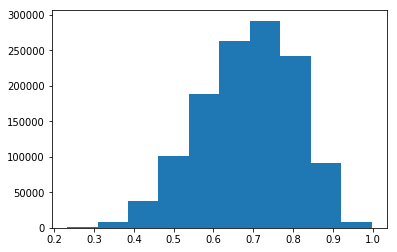

In [79]:
plt.hist(score_vector)

## Human performance

In [259]:
trn = m_part1_trn
ndx = m_part1_ndx

val_dataloader = init_embed_loaders(options, trn) 
trn_embeddings, _ = embeds(options, val_dataloader, model, lda)

embed_dim = trn_embeddings.shape[-1]
trn_id = list(trn.id.unique())
spk_model_dict = {}
for id in trn_id:
    index = np.nonzero(trn.id == id)
    spk_model_dict[id] = trn_embeddings[index].mean(0, True)

all_trials = ndx.id.unique().tolist()
scores = dict()
for t in range(4):
    scores[t] = []

trial_id = all_trials[99]
print(trial_id)
trial_ndx = ndx[(ndx.id == trial_id)].reset_index()
trial_embed_idx = np.nonzero(m_part1_files.file.isin(trial_ndx.file))
trial_embeds = ndx_embeddings[trial_embed_idx]
sim = F.cosine_similarity(trial_embeds, spk_model_dict[trial_id])
for t in range(4):
    trial_type_idx = trial_ndx[trial_ndx.trial_type == t].index.tolist()
    scores[t].append(sim[trial_type_idx])
        
# [TC, TW, IC, IW]
for t in range(4):
    scores[t] = torch.cat(scores[t])

from sklearn.metrics import roc_curve

for t in range(1,4):
    score_vector = np.concatenate((scores[0], scores[t]))
    label_vector = np.concatenate((np.ones(len(scores[0])), 
                               np.zeros(len(scores[t]))))
    fpr, tpr, thres = roc_curve(label_vector, score_vector, pos_label=1)
    eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
    thres = thres[np.nanargmin(np.abs(fpr - (1 - tpr)))]
    print("[{}] eer: {:.2f}, thres: {:.5f}".format(err_type[t], eer, thres))

enroll_df = trn[trn.id == trial_id] 
enroll_df['trial_type'] = -1

# row scores in pos_test
t_type = 0
n_test = 5
hard_pos_test = np.argsort(scores[t_type])[:n_test]
pos_test_df = trial_ndx[trial_ndx.trial_type == t_type].iloc[hard_pos_test]

t_type = 2
hard_neg_test = np.argsort(scores[t_type])[-n_test:]
neg_test_df =trial_ndx[trial_ndx.trial_type == t_type].iloc[hard_neg_test]

from shutil import copyfile
trial_folder = "trials/human_perf/reddots/{}".format(trial_id)
if not os.path.isdir(trial_folder):
    os.makedirs(trial_folder)

test_df = pd.concat([pos_test_df, neg_test_df])
perm_idxs = np.random.permutation(np.arange(len(test_df)))

i = 0
for idx, row in enroll_df.iterrows():
    copyfile(os.path.join(options.data_folder, row.file), 
             os.path.join(trial_folder, "e_{}.wav".format(i)))
    i+=1

i = 0
random_idx = np.random.permutation(np.arange(len(test_df)))
save_file_names = []
for _, row in test_df.iterrows():
    save_file_names.append("t_{}.wav".format(perm_idxs[i]))
    copyfile(os.path.join(options.data_folder, row.file), 
             os.path.join(trial_folder, save_file_names[-1]))
    i+=1

test_df['to_file'] = save_file_names

with open(os.path.join(trial_folder, "test_labels.txt"), "w") as f:
    for _, row in test_df.iterrows():
        if row.trial_type == 0:
            f.write("{}\t{}\n".format(row.to_file, "1"))
        else:
            f.write("{}}\t{}\n".format(row_to_file, "0"))

test_df.to_pickle(os.path.join(trial_folder, "test_audios.pkl"))

### performance test

In [257]:
all_trials = ndx.id.unique().tolist()
scores = dict()
for t in [0, 2]:
    scores[t] = []

print(trial_id)
trial_ndx = ndx[(ndx.id == trial_id)].reset_index()
trial_embed_idx = np.nonzero(m_part1_files.file.isin(trial_ndx.file))
trial_embeds = ndx_embeddings[trial_embed_idx]
sim = F.cosine_similarity(trial_embeds, spk_model_dict[trial_id])
for t in [0, 2]:
    trial_type_idx = trial_ndx[trial_ndx.trial_type == t].index.tolist()
    scores[t].append(sim[trial_type_idx])
        
# [TC, TW, IC, IW]
for t in [0, 2]:
    scores[t] = torch.cat(scores[t])

from sklearn.metrics import roc_curve


for t in range(2,3):
    score_vector = np.concatenate((scores[0], scores[t]))
    label_vector = np.concatenate((np.ones(len(scores[0])), 
                               np.zeros(len(scores[t]))))
    fpr, tpr, thres = roc_curve(label_vector, score_vector, pos_label=1)
    eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
    thres = thres[np.nanargmin(np.abs(fpr - (1 - tpr)))]
    print("[{}] eer: {:.2f}, thres: {:.5f}".format(err_type[t], eer, thres))

m0001_39
